In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [5]:
from freud.density import CorrelationFunction

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        new_df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/softness-corr-frames_period-{period}.npz"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
        else:
            continue
        
        traj = gsd.hoomd.open(exper)
        
        # softs = np.stack(dataset["soft"].to_numpy())[:-1]
        # nsofts = softs.reshape(5, 40, 32768)
        # nsofts = nsofts.mean(axis=0)

        # # compute fft
        # soft_ffts = np.fft.fft(nsofts.T, axis=-1)

        # snap = traj[dataset["frame"][0]]

        # if job.isfile(new_df_path):
        #     continue

        corr = CorrelationFunction(20, 5.0)
        # corr2 = CorrelationFunction(25, 5.0)

        corr_output = []
        frames = []

        for frame, _, soft in dataset.rows()[::20]:
            # print(frame)
            frames.append(frame)
            soft = np.array(soft)
            soft = (soft - soft.mean()) / soft.std()
            snap = traj[frame]
            corr.compute(snap, soft, reset=True)
            corr_output.append(corr.correlation)
            # s = (soft < 0.0) & (soft > -0.5)
            # query_points = snap.particles.position
            # query_vals = (soft > 0.0).astype(np.float32)
            # corr.compute(snap, soft, query_points=query_points, query_values=query_vals, reset=False)
            # corr_output.append(corr.correlation)
            # query_points = snap.particles.position[~s]
            # query_vals = soft[~s]
            # corr2.compute(snap, soft, query_points=query_points, query_values=query_vals, reset=False)
            # break

        bcs = corr.bin_centers

        # output[sp].append(corr_output)
        np.savez(job.fn(new_df_path), bcs=corr.bin_centers, corr=np.array(corr_output), frame=frames)

    #     break
    # break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


In [6]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/softness-corr-frames_period-{period}.npz"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)

        if float(period) != 1000.0 or float(temp) > 5e-3:
            continue

        if os.path.exists(job.fn(df_path)):
            data = np.load(job.fn(df_path))
            output[sp].append(data)

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


/tmp/ipykernel_3314800/1838574464.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")


Text(0.5, 0, '$\\Delta x$')

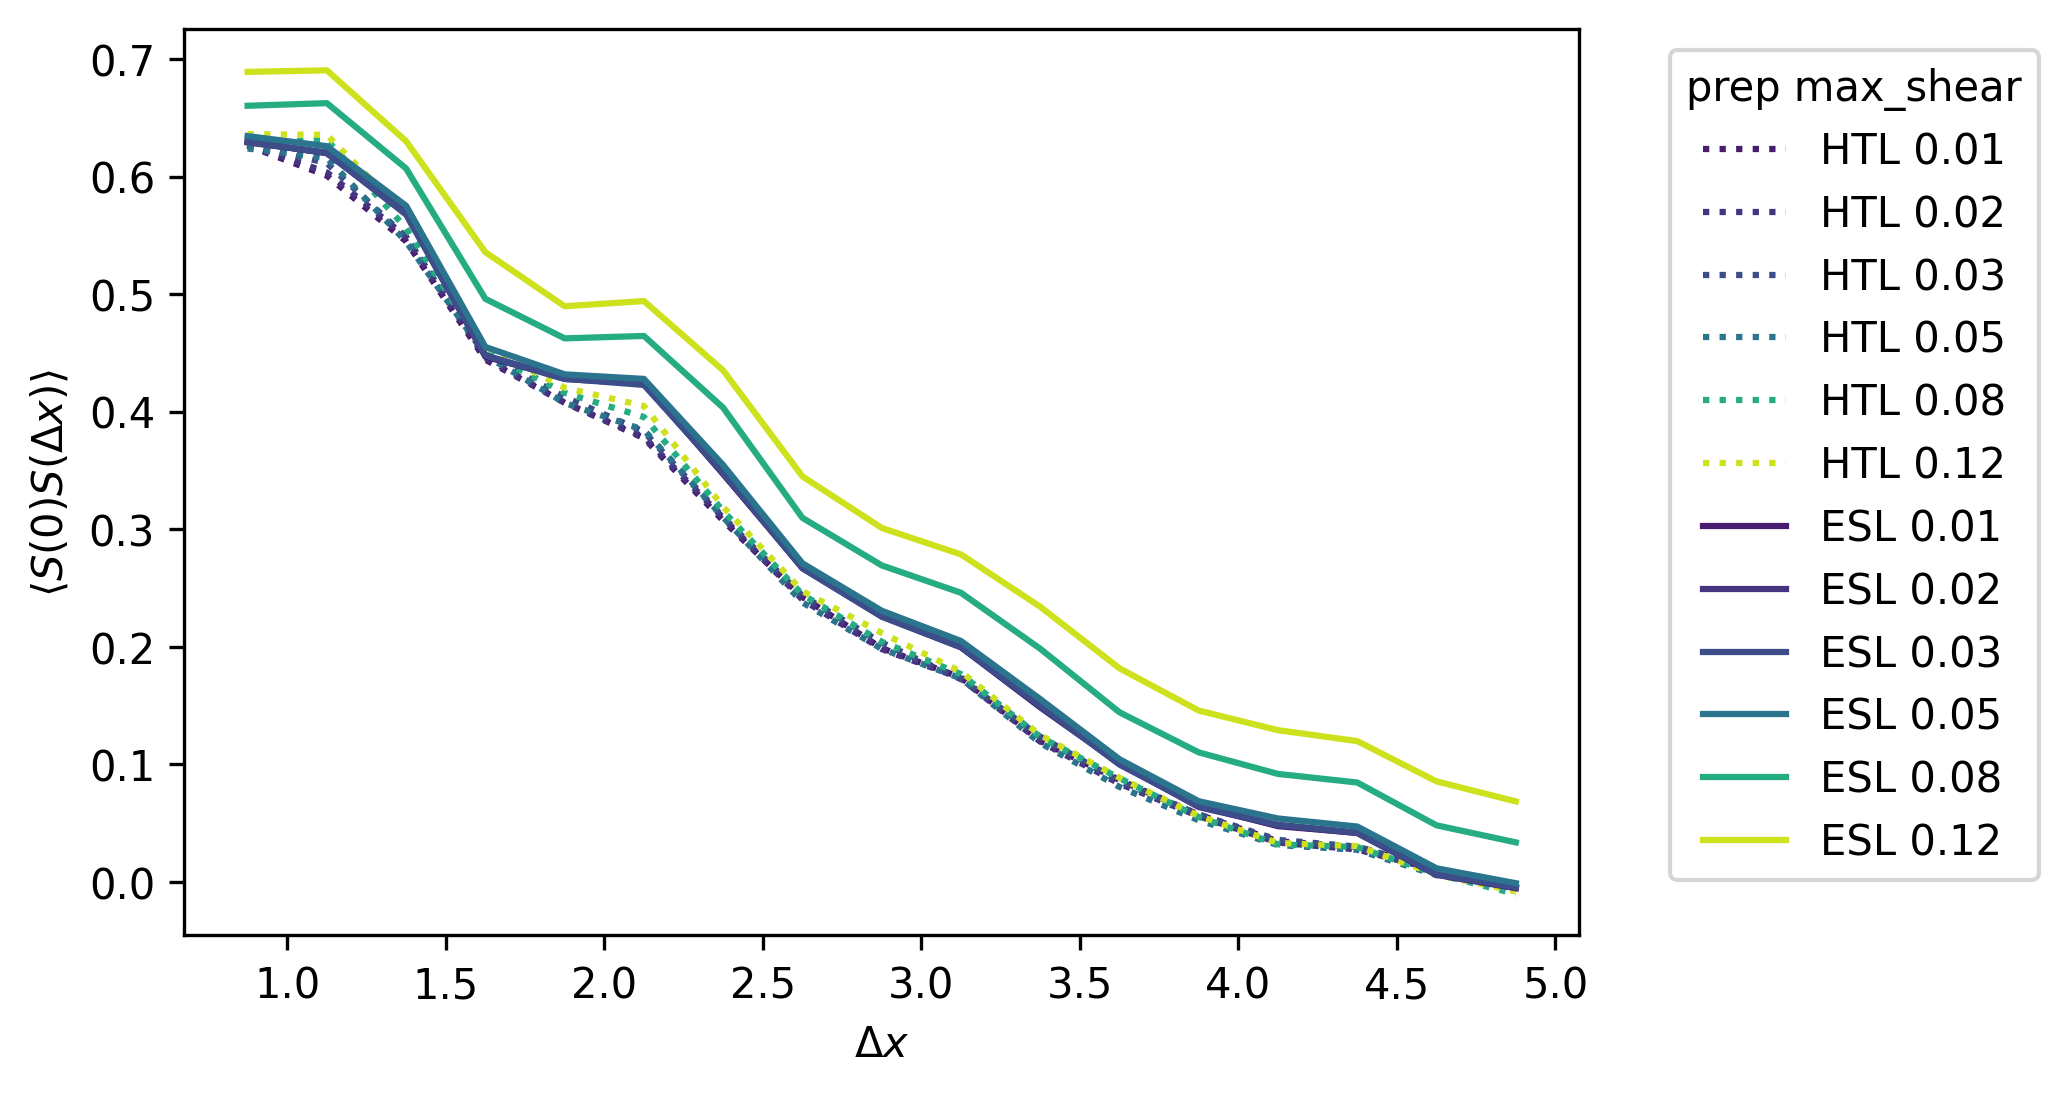

In [7]:
cmap = cm.get_cmap("viridis")
plt.figure(dpi=150)
# norm = colors.Normalize(vmin=0, vmax=1)
norm = colors.Normalize(vmin=0, vmax=1.3e-1)
for key, values in output.items():
    # print(key.prep)
    if key.prep == "ESL":
        ln = "-"
    else:
        ln = ":"
    value = values[0]
    bcs = value["bcs"]
    out = np.mean([value["corr"][0] for value in values], axis=0)
    # for idx, out in enumerate(corr_output):
    plt.plot(bcs[3:], out[3:], linestyle=ln, color=cmap(norm(key.max_shear)), label=f"{key.prep} {key.max_shear:.2f}")

# plt.yscale('log')orr_output
# plt.yscale('log')
plt.legend(title="prep max_shear", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel(r"$\langle \bar S(0) \bar S(\Delta x) \rangle$")
plt.xlabel(r"$\Delta x$")

In [54]:
handle = np.load(job.fn(new_df_path))

In [57]:
dict(handle)

{'bcs': array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25,
        5.75, 6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75]),
 'corr': array([[0.        , 0.35328442, 0.31771948, 0.26480397, 0.21887965,
         0.18811145, 0.13668508, 0.11075708, 0.08955435, 0.06612248,
         0.06997194, 0.05332465, 0.06391256, 0.05475339, 0.05772902,
         0.05555217, 0.05319416, 0.05556921, 0.05001342, 0.05278491]]),
 'frame': array([39])}